In [5]:
# Import important libraries
import sys, os, time, importlib, glob, pdb
import numpy as np
import matplotlib.pyplot as plt
import math
plt.rcParams.update(plt.rcParamsDefault)
from matplotlib import rc
from os import listdir
import OutflowsCGMInteractionTools.AnalysisTools as l
import OutflowsCGMInteractionTools.HalosData as HD
from astropy import units as u
from astropy import constants as const
from math import nan, isnan
G=const.G.to('km^3/M_sun*s^2')
###############################################################

In [32]:
# Important Functions
def FindClosest(lst,K):
    # Finds the closest element in an array for a given value
    return lst[min(range(len(lst)),key=lambda i: abs(float(lst[i])-K))]

# Creates a list of the redshifts in m12i_res7100 data (the files Jonathan sent)
ListOfFiles=os.listdir("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/m12i_res7100Data/")
ListOfRedshiftsTheo=[]
for i in ListOfFiles:
    RedshiftTheo=i.replace("._profiler_m12i_md_7100_z","")
    RedshiftTheo=RedshiftTheo.replace("profiler_m12i_md_7100_z","")
    RedshiftTheo=RedshiftTheo.replace(".npz","")
    RedshiftTheo=float(RedshiftTheo)
    ListOfRedshiftsTheo.append("{:.4f}".format(RedshiftTheo))
    
def FindTheTotalMassWithinSpecificRadiusInSpecificRedShift(Redshift,Radius):
    # Calculates the total mass within spesific radius for a given redshift (all mass profiles are included)
    ClosestRedshift=FindClosest(ListOfRedshiftsTheo,Redshift)
    Data= np.load("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/m12i_res7100Data/profiler_m12i_md_7100_z"+str(ClosestRedshift)+".npz",allow_pickle=True)
    ClosestR=FindClosest(Data['rs_midbins'],Radius)
    Index=np.where(Data['rs_midbins']==ClosestR)
    M=Data['massProfile0'][Index]+Data['massProfile1'][Index]+Data['massProfile2'][Index]+Data['massProfile4'][Index]
    return(M)

def FindEpForAGivenParticle(Redshift,Radius):
    # Calculates the potential energey Ep for a given radius and redshift 
    Redshifts=np.load("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/TrackingData/TrackingFrom465To600/AllRedshifts.npz",allow_pickle=True)['arr_0']
    RsonicForEachRedshift=np.load("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/TrackingData/TrackingFrom465To600/RsonicForEachRedshift.npz",allow_pickle=True)['arr_0']
    dr=[]
    ClosestRedshiftInm12iData=FindClosest(ListOfRedshiftsTheo,Redshift)
    ClosestRedshiftInRedshiftsArray=FindClosest(Redshifts,Redshift)
    IndexOfRedshiftInRedshiftsAarray=np.where(Redshifts==ClosestRedshiftInRedshiftsArray)
    Data= np.load("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/m12i_res7100Data/profiler_m12i_md_7100_z"+str(ClosestRedshiftInm12iData)+".npz",allow_pickle=True)    
    rs_midbins=Data['rs_midbins']
    Rsonic=RsonicForEachRedshift[IndexOfRedshiftInRedshiftsAarray][0] # In kpc
    RsonicInUnitsOfkm=Rsonic*u.kpc.to("km")
    rs_midbinsInUnitsOfkm=rs_midbins*u.kpc.to("km")
    ParticleRadiusInUnitsOfkm=Radius*u.kpc.to("km")
    for i in range(0,len(rs_midbins)-1):
        Delta=rs_midbins[i+1]-rs_midbins[i]
        dr.append(Delta)
    dr.append(Delta)
    dr=np.array(dr)
    drInUnitsOfkm=dr*u.kpc.to("km")
    massProfile0=Data['massProfile0']
    massProfile1=Data['massProfile1']
    massProfile2=Data['massProfile2']
    massProfile4=Data['massProfile4']
    M=massProfile0+massProfile1+massProfile2+massProfile4
    CumSumM=np.cumsum(M)
    rs_midbinsInUnitsOfkmSquare=rs_midbinsInUnitsOfkm**2
    Integrand=G.value*CumSumM*drInUnitsOfkm/rs_midbinsInUnitsOfkmSquare
    if(ParticleRadiusInUnitsOfkm<RsonicInUnitsOfkm):
        MinIndexForSum=np.where(rs_midbinsInUnitsOfkm>=ParticleRadiusInUnitsOfkm)
        MaxIndexForSum=np.where(rs_midbinsInUnitsOfkm<=RsonicInUnitsOfkm)
        IndexesToSum=np.intersect1d(MinIndexForSum, MaxIndexForSum)   
    else:
        MinIndexForSum=np.where(rs_midbinsInUnitsOfkm<=ParticleRadiusInUnitsOfkm)
        MaxIndexForSum=np.where(rs_midbinsInUnitsOfkm>=RsonicInUnitsOfkm)
        IndexesToSum=np.intersect1d(MinIndexForSum, MaxIndexForSum)    
    Ep=0
    for i in IndexesToSum:
        Ep=Ep+Integrand[i]
    return Ep

def Cartesian_To_Spherical(x,y,z):
    # Calculates spherical theta and phi for a given caratezian coordinates [x,y,z]
    theta=math.atan2(math.sqrt(x**2+y**2),z)
    phi=math.atan2(y,x) if x >= 0 else math.atan2(y,x) + math.pi
    return theta, phi

def align_vectors(a,b):
    # Finds the matrix that align two vectors
    b=b/np.linalg.norm(b) # Normalize a
    a=a/np.linalg.norm(a) # Normalize b
    v=np.cross(a, b)
    c=np.dot(a, b)
    v1,v2,v3 = v
    h=1/(1+c)
    Vmat=np.array([[0,-v3,v2],
                  [v3,0,-v1],
                  [-v2,v1,0]])
    R=np.eye(3,dtype=np.float64)+Vmat+(Vmat.dot(Vmat)*h)
    return R

def FindMEnclosed(Redshift,Radius):
    # Calculates the M Enclosed for a given radius and redshift
    # Calculates the M Enclosed for a givem radius and redshift different types
    AllRedshifts=np.load("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/TrackingData/TrackingFrom465To600/AllRedshifts.npz",allow_pickle=True)['arr_0']
    ClosestRedshiftInm12iData=FindClosest(ListOfRedshiftsTheo,Redshift)
    ClosestRedshiftInRedshiftsArray=FindClosest(AllRedshifts,Redshift)
    IndexOfRedshiftInRedshiftsAarray=np.where(AllRedshifts==ClosestRedshiftInRedshiftsArray)
    Data= np.load("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/m12i_res7100Data/profiler_m12i_md_7100_z"+str(ClosestRedshiftInm12iData)+".npz",allow_pickle=True)    
    rs_midbins=Data['rs_midbins']
    massProfile0=Data['massProfile0']
    massProfile1=Data['massProfile1']
    massProfile2=Data['massProfile2']
    massProfile4=Data['massProfile4']
    M=massProfile0+massProfile1+massProfile2+massProfile4
    CumSumM=np.cumsum(M)
    massProfile0CumSum=np.cumsum(massProfile0)
    massProfile1CumSum=np.cumsum(massProfile1)
    massProfile2CumSum=np.cumsum(massProfile2)
    massProfile4CumSum=np.cumsum(massProfile4)
    RelevantIndexesForSumTheMasses=np.where(rs_midbins<=Radius)[0]
    
    MEnclosed=CumSumM[len(RelevantIndexesForSumTheMasses)-1]
    massProfile0Enclosed=massProfile0CumSum[len(RelevantIndexesForSumTheMasses)-1]
    massProfile1Enclosed=massProfile1CumSum[len(RelevantIndexesForSumTheMasses)-1]
    massProfile2Enclosed=massProfile2CumSum[len(RelevantIndexesForSumTheMasses)-1]
    massProfile4Enclosed=massProfile4CumSum[len(RelevantIndexesForSumTheMasses)-1]

    return MEnclosed,massProfile0Enclosed,massProfile1Enclosed,massProfile2Enclosed,massProfile4Enclosed

In [ ]:
# Saves an array of Rsonic for all redshifts
Redshifts=np.load("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/TrackingData/TrackingFrom465To600/AllRedshifts.npz",allow_pickle=True)['arr_0']
RsonicForEachRedshift=[]
for i in Redshifts:
    ClosestRedshift=FindClosest(ListOfRedshiftsTheo,i)
    TempLoad=np.load("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/m12i_res7100Data/profiler_m12i_md_7100_z"+str(ClosestRedshift)+".npz",allow_pickle=True)
    Radiuses=TempLoad['rs_midbins'][0:258] # Only Radiuses Under 100 Kpc
    SubsonicFractionMW=TempLoad['subsonic_fraction_MW'][0:258]
    MaxSubsonicFractionMW=np.max(SubsonicFractionMW)
    MinSubsonicFractionMW=np.min(SubsonicFractionMW)
    AvarageSubsonicFractionMW=(MaxSubsonicFractionMW+MinSubsonicFractionMW)/2
    SubsonicFractionMWWithoutnanValues = [x for x in SubsonicFractionMW if isnan(x) == False]
    ClosestSubsonicToAvarage=FindClosest(SubsonicFractionMWWithoutnanValues,AvarageSubsonicFractionMW)
    IndexOfClosestSubsonicToAvarage=np.where(SubsonicFractionMW==ClosestSubsonicToAvarage)[0][0]
    ROfClosestSubsonicToAvarage=Radiuses[IndexOfClosestSubsonicToAvarage]
    RsonicForEachRedshift.append(ROfClosestSubsonicToAvarage)
RsonicForEachRedshift=np.array(RsonicForEachRedshift)

np.savez_compressed("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/TrackingData/TrackingFrom465To600/RsonicForEachRedshift.npz",RsonicForEachRedshift,dtype=float)

In [37]:
# Tracking from 465 to 600 ~ from z=0.25 to z=0 
# Collect data from all the SnapNumber.npz files
# Saves 15 npz files: AllRedshifts, AllSnapnumbers, AllParticlesCoordinates, AllParticlesDensities, AllParticlesEI, AllParticlesIDS, 
# AllParticlesMasses, AllParticlesNeutralH, AllParticlesNewCoordinates, AllParticlesNewVelocitiesVxVyVz, AllParticlesRs, 
# AllParticlesSmoothingLengths, AllParticlesTemperatures, AllParticlesVelocitiesVrVphiVtheta, AllParticlesVelocitiesVxVyVz
AllRedshifts=[]
AllSnapnumbers=[]
AllParticlesIDS=[]
AllParticlesCoordinates=[]
AllParticlesNewCoordinates=[]
AllParticlesRs=[]
AllParticlesMasses=[]
AllParticlesDensities=[]
AllParticlesTemperatures=[]
AllParticlesNeutralH=[]
AllParticlesSmoothingLengths=[]
AllParticlesVelocitiesVxVyVz=[]
AllParticlesNewVelocitiesVxVyVz=[]
AllParticlesVelocitiesVrVphiVtheta=[]
AllParticlesEI=[]

for i in range(465,601):
    snapnumber=str(i)+".0.npz"
    SnapshotData=np.load("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/TrackingData/TrackingFrom465To600/"+snapnumber,allow_pickle=True)['arr_0']
    AllRedshifts.append(SnapshotData[0])
    AllSnapnumbers.append(SnapshotData[1])
AllRedshifts=np.array(AllRedshifts)
AllSnapnumbers=np.array(AllSnapnumbers)

np.savez_compressed("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/TrackingData/TrackingFrom465To600/AllRedshifts.npz",AllRedshifts,dtype=float)
np.savez_compressed("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/TrackingData/TrackingFrom465To600/AllSnapnumbers.npz",AllSnapnumbers,dtype=float)

for i in range(0,1000):
    ParticlesIDS=[]
    ParticlesCoordinates=[]
    ParticlesNewCoordinates=[]
    ParticlesRs=[]
    ParticlesMasses=[]
    ParticlesDensities=[]
    ParticlesTemperatures=[]
    ParticlesNeutralH=[]
    ParticlesSmoothingLengths=[]
    ParticlesVelocitiesVxVyVz=[]
    ParticlesNewVelocitiesVxVyVz=[]
    ParticlesVelocitiesVrVphiVtheta=[]
    ParticlesEI=[]
    for j in range (465,601):
        snapnumber=str(j)+".0.npz"
        SnapshotData=np.load("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/TrackingData/TrackingFrom465To600/"+snapnumber,allow_pickle=True)['arr_0']
        ClosestRedshiftInm12iData=FindClosest(ListOfRedshiftsTheo,SnapshotData[0])
        Data=np.load("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/m12i_res7100Data/profiler_m12i_md_7100_z"+str(ClosestRedshiftInm12iData)+".npz",allow_pickle=True)    
        ParticlesIDS.append(SnapshotData[2][i])
        ParticlesCoordinates.append(SnapshotData[3][i])
        x=SnapshotData[3][i][0]
        y=SnapshotData[3][i][1]
        z=SnapshotData[3][i][2]
        ParticlesRs.append(SnapshotData[4][i])
        ParticlesMasses.append(SnapshotData[5][i])
        ParticlesDensities.append(SnapshotData[6][i])
        ParticlesTemperatures.append(SnapshotData[7][i])
        ParticlesNeutralH.append(SnapshotData[8][i])
        ParticlesSmoothingLengths.append(SnapshotData[9][i])
        ParticlesVelocitiesVxVyVz.append(SnapshotData[10][i])
        Vx=SnapshotData[10][i][0]
        Vy=SnapshotData[10][i][1]
        Vz=SnapshotData[10][i][2]
        ParticlesEI.append(SnapshotData[11][i])
        
        j_vec_xXmassProfile0=Data['j_vec_x']*Data['massProfile0']
        j_vec_yXmassProfile0=Data['j_vec_y']*Data['massProfile0']
        j_vec_zXmassProfile0=Data['j_vec_z']*Data['massProfile0']
        Jx=np.nansum(j_vec_xXmassProfile0)
        Jy=np.nansum(j_vec_yXmassProfile0)
        Jz=np.nansum(j_vec_zXmassProfile0)
        OldJVector=np.array([Jx,Jy,Jz])
        NewJVector=np.array([0,0,1])
        Matrix=align_vectors(OldJVector,NewJVector)
        RcaratzainNew=Matrix.dot(SnapshotData[3][i])
        ParticlesNewCoordinates.append(RcaratzainNew)
        VcaratezianNew=Matrix.dot(SnapshotData[10][i])
        ParticlesNewVelocitiesVxVyVz.append(VcaratezianNew)
        VxNew=VcaratezianNew[0]
        VyNew=VcaratezianNew[1]
        VzNew=VcaratezianNew[2]
        Theta,Phi=Cartesian_To_Spherical(RcaratzainNew[0],RcaratzainNew[1],RcaratzainNew[2])
        Vr=VxNew*np.sin(Theta)*np.cos(Phi)+VyNew*np.sin(Theta)*np.sin(Phi)+VzNew*np.cos(Theta)
        Vphi=-VxNew*np.sin(Phi)+VyNew*np.cos(Phi)
        Vtheta=VxNew*np.cos(Theta)*np.cos(Phi)+VyNew*np.cos(Theta)*np.sin(Phi)-VzNew*np.sin(Theta)
        Vspherical=np.array([Vr,Vphi,Vtheta])
        ParticlesVelocitiesVrVphiVtheta.append(Vspherical)
        
    ParticlesIDS=np.array(ParticlesIDS)
    ParticlesCoordinates=np.array(ParticlesCoordinates)
    ParticlesNewCoordinates=np.array(ParticlesNewCoordinates)
    ParticlesRs=np.array(ParticlesRs)
    ParticlesMasses=np.array(ParticlesMasses)
    ParticlesDensities=np.array(ParticlesDensities)
    ParticlesTemperatures=np.array(ParticlesTemperatures)
    ParticlesNeutralH=np.array(ParticlesNeutralH)
    ParticlesSmoothingLengths=np.array(ParticlesSmoothingLengths)
    ParticlesVelocitiesVxVyVz=np.array(ParticlesVelocitiesVxVyVz)
    ParticlesNewVelocitiesVxVyVz=np.array(ParticlesNewVelocitiesVxVyVz)
    ParticlesVelocitiesVrVphiVtheta=np.array(ParticlesVelocitiesVrVphiVtheta)
    ParticlesEI=np.array(ParticlesEI)
    
    AllParticlesIDS.append(ParticlesIDS)
    AllParticlesCoordinates.append(ParticlesCoordinates)
    AllParticlesNewCoordinates.append(ParticlesNewCoordinates)
    AllParticlesRs.append(ParticlesRs)
    AllParticlesMasses.append(ParticlesMasses)
    AllParticlesDensities.append(ParticlesDensities)
    AllParticlesTemperatures.append(ParticlesTemperatures)
    AllParticlesNeutralH.append(ParticlesNeutralH)
    AllParticlesSmoothingLengths.append(ParticlesSmoothingLengths)
    AllParticlesVelocitiesVxVyVz.append(ParticlesVelocitiesVxVyVz)
    AllParticlesNewVelocitiesVxVyVz.append(ParticlesNewVelocitiesVxVyVz)
    AllParticlesVelocitiesVrVphiVtheta.append(ParticlesVelocitiesVrVphiVtheta)
    AllParticlesEI.append(ParticlesEI)
    
AllParticlesIDS=np.array(AllParticlesIDS)
AllParticlesCoordinates=np.array(AllParticlesCoordinates)
AllParticlesNewCoordinates=np.array(AllParticlesNewCoordinates)
AllParticlesRs=np.array(AllParticlesRs)
AllParticlesMasses=np.array(AllParticlesMasses)
AllParticlesDensities=np.array(AllParticlesDensities)
AllParticlesTemperatures=np.array(AllParticlesTemperatures)
AllParticlesNeutralH=np.array(AllParticlesNeutralH)
AllParticlesSmoothingLengths=np.array(AllParticlesSmoothingLengths)
AllParticlesVelocitiesVxVyVz=np.array(AllParticlesVelocitiesVxVyVz)
AllParticlesNewVelocitiesVxVyVz=np.array(AllParticlesNewVelocitiesVxVyVz)
AllParticlesVelocitiesVrVphiVtheta=np.array(AllParticlesVelocitiesVrVphiVtheta)
AllParticlesEI=np.array(AllParticlesEI)

np.savez_compressed("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/TrackingData/TrackingFrom465To600/AllParticlesIDS.npz",AllParticlesIDS,dtype=float)
np.savez_compressed("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/TrackingData/TrackingFrom465To600/AllParticlesCoordinates.npz",AllParticlesCoordinates,dtype=float)
np.savez_compressed("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/TrackingData/TrackingFrom465To600/AllParticlesNewCoordinates.npz",AllParticlesNewCoordinates,dtype=float)
np.savez_compressed("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/TrackingData/TrackingFrom465To600/AllParticlesRs.npz",AllParticlesRs,dtype=float)
np.savez_compressed("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/TrackingData/TrackingFrom465To600/AllParticlesMasses.npz",AllParticlesMasses,dtype=float)
np.savez_compressed("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/TrackingData/TrackingFrom465To600/AllParticlesDensities.npz",AllParticlesDensities,dtype=float)
np.savez_compressed("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/TrackingData/TrackingFrom465To600/AllParticlesTemperatures.npz",AllParticlesTemperatures,dtype=float)
np.savez_compressed("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/TrackingData/TrackingFrom465To600/AllParticlesNeutralH.npz",AllParticlesNeutralH,dtype=float)
np.savez_compressed("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/TrackingData/TrackingFrom465To600/AllParticlesSmoothingLengths.npz",AllParticlesSmoothingLengths,dtype=float)
np.savez_compressed("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/TrackingData/TrackingFrom465To600/AllParticlesVelocitiesVxVyVz.npz",AllParticlesVelocitiesVxVyVz,dtype=float)
np.savez_compressed("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/TrackingData/TrackingFrom465To600/AllParticlesNewVelocitiesVxVyVz.npz",AllParticlesNewVelocitiesVxVyVz,dtype=float)
np.savez_compressed("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/TrackingData/TrackingFrom465To600/AllParticlesVelocitiesVrVphiVtheta.npz",AllParticlesVelocitiesVrVphiVtheta,dtype=float)
np.savez_compressed("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/TrackingData/TrackingFrom465To600/AllParticlesEI.npz",AllParticlesEI,dtype=float)

In [3]:
# Saves 3 arrays: AllParticelsEK, AllParticelsEP, AllParticlesEtot
AllParticlesRs=np.load("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/TrackingData/TrackingFrom465To600/AllParticlesRs.npz",allow_pickle=True)['arr_0']
AllParticlesEI=np.load("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/TrackingData/TrackingFrom465To600/AllParticlesEI.npz",allow_pickle=True)['arr_0']
AllParticlesVelocitiesVrVphiVtheta=np.load("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/TrackingData/TrackingFrom465To600/AllParticlesVelocitiesVrVphiVtheta.npz",allow_pickle=True)['arr_0']
AllRedshifts=np.load("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/TrackingData/TrackingFrom465To600/AllRedshifts.npz",allow_pickle=True)['arr_0']
AllParticlesEK=[]
AllParticlesEP=[]
AllParticlesEtot=[]
for i in range(0,1000):
    ParticleEKs=[]
    ParticleEPs=[]
    ParticleEtots=[]
    for j in range (0,136):
        ParticleR=AllParticlesRs[i][j]
        ParticleVr=AllParticlesVelocitiesVrVphiVtheta[i][j][0]
        ParticleEK=0.5*(ParticleVr**2)
        ParticleEKs.append(ParticleEK)
        ParticleEP=FindEpForAGivenParticle(AllRedshifts[j],ParticleR)
        ParticleEPs.append(ParticleEP)
        ParticleEI=AllParticlesEI[i][j]
        if(ParticleEI!=None):
            ParticleEtot=ParticleEK+ParticleEP+ParticleEI
        else:
            ParticleEtot=ParticleEK+ParticleEP
        ParticleEtots.append(ParticleEtot)
    ParticleEKs=np.array(ParticleEKs)
    ParticleEPs=np.array(ParticleEPs)
    ParticleEtots=np.array(ParticleEtots)
    AllParticlesEK.append(ParticleEKs)
    AllParticlesEP.append(ParticleEPs)
    AllParticlesEtot.append(ParticleEtots)
AllParticlesEK=np.array(AllParticlesEK)
AllParticlesEP=np.array(AllParticlesEP)  
AllParticlesEtot=np.array(AllParticlesEtot)

np.savez_compressed("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/TrackingData/TrackingFrom465To600/AllParticlesEK.npz",AllParticlesEK,dtype=float)
np.savez_compressed("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/TrackingData/TrackingFrom465To600/AllParticlesEP.npz",AllParticlesEP,dtype=float)
np.savez_compressed("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/TrackingData/TrackingFrom465To600/AllParticlesEtot.npz",AllParticlesEtot,dtype=float)

In [16]:
# Saves 6 arrays: Rmax, Rmin, z in Rmax, z in Rmin, Etot in Rmax, Etot in Rmin
AllParticlesRs=np.load("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/TrackingData/TrackingFrom465To600/AllParticlesRs.npz",allow_pickle=True)['arr_0']
AllParticlesEtot=np.load("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/TrackingData/TrackingFrom465To600/AllParticlesEtot.npz",allow_pickle=True)['arr_0']
AllRedshifts=np.load("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/TrackingData/TrackingFrom465To600/AllRedshifts.npz",allow_pickle=True)['arr_0']
AllParticlesRmax=[]
AllParticlesRmin=[]
AllParticlesRedshiftinRmax=[]
AllParticlesRedshiftinRmin=[]
AllParticlesETotalInRmax=[]
AllParticlesETotalInRmin=[]
for i in range(0,1000):
    ParticleRs=AllParticlesRs[i]
    
    Rmax=np.max(ParticleRs)
    IndexOfRmax=np.where(ParticleRs==Rmax)
    AllParticlesRmax.append(Rmax)
    AllParticlesRedshiftinRmax.append(AllRedshifts[IndexOfRmax][0])
    AllParticlesETotalInRmax.append(AllParticlesEtot[IndexOfRmax][0])
    
    Rmin=np.min(ParticleRs)
    IndexOfRmin=np.where(ParticleRs==Rmin)
    AllParticlesRmin.append(Rmin)
    AllParticlesRedshiftinRmin.append(AllRedshifts[IndexOfRmin][0])
    AllParticlesETotalInRmin.append(AllParticlesEtot[IndexOfRmin][0])
       
AllParticlesRmax=np.array(AllParticlesRmax)
AllParticlesRmin=np.array(AllParticlesRmin)
AllParticlesRedshiftinRmax=np.array(AllParticlesRedshiftinRmax)
AllParticlesRedshiftinRmin=np.array(AllParticlesRedshiftinRmin)
AllParticlesETotalInRmax=np.array(AllParticlesETotalInRmax)
AllParticlesETotalInRmin=np.array(AllParticlesETotalInRmin)

np.savez_compressed("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/TrackingData/TrackingFrom465To600/AllParticlesRmax.npz",AllParticlesRmax,dtype=float)
np.savez_compressed("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/TrackingData/TrackingFrom465To600/AllParticlesRmin.npz",AllParticlesRmin,dtype=float)
np.savez_compressed("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/TrackingData/TrackingFrom465To600/AllParticlesRedshiftinRmax.npz",AllParticlesRedshiftinRmax,dtype=float)
np.savez_compressed("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/TrackingData/TrackingFrom465To600/AllParticlesRedshiftinRmin.npz",AllParticlesRedshiftinRmin,dtype=float)
np.savez_compressed("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/TrackingData/TrackingFrom465To600/AllParticlesETotalInRmax.npz",AllParticlesETotalInRmax,dtype=float)
np.savez_compressed("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/TrackingData/TrackingFrom465To600/AllParticlesETotalInRmin.npz",AllParticlesETotalInRmin,dtype=float)

In [18]:
# Saves 4 arrays: AvarageRmax, RedshiftsForAvarageRmax, AvarageRmin, RedshiftsForAvarageRmin
AllParticlesRedshiftinRmax=np.load("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/TrackingData/TrackingFrom465To600/AllParticlesRedshiftinRmax.npz",allow_pickle=True)['arr_0']
AllParticlesRedshiftinRmin=np.load("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/TrackingData/TrackingFrom465To600/AllParticlesRedshiftinRmin.npz",allow_pickle=True)['arr_0']

AllParticlesRmax=np.load("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/TrackingData/TrackingFrom465To600/AllParticlesRmax.npz",allow_pickle=True)['arr_0']
AllParticlesRmin=np.load("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/TrackingData/TrackingFrom465To600/AllParticlesRmin.npz",allow_pickle=True)['arr_0']

RedshiftsForAvarageRmax=[]
RedshiftsForAvarageRmin=[]
AvarageRmax=[]
AvarageRmin=[]

while(len(AllParticlesRedshiftinRmax)>0):
    MinRedshift=np.min(AllParticlesRedshiftinRmax)
    RedshiftsForAvarageRmax.append(MinRedshift)
    IndexOfMinRedshift=np.where(AllParticlesRedshiftinRmax==MinRedshift)
    RmaxesSum=0
    NumberOfParticles=len(IndexOfMinRedshift[0])
    for i in (IndexOfMinRedshift[0]):
        RmaxesSum=RmaxesSum+AllParticlesRmax[i]
    RmaxAvargeInSpecificRedshift=RmaxesSum/NumberOfParticles
    AvarageRmax.append(RmaxAvargeInSpecificRedshift)
    
    AllParticlesRedshiftinRmax=np.delete(AllParticlesRedshiftinRmax,IndexOfMinRedshift[0])
    AllParticlesRmax=np.delete(AllParticlesRmax,IndexOfMinRedshift[0])

while(len(AllParticlesRedshiftinRmin)>0):
    MinRedshift=np.min(AllParticlesRedshiftinRmin)
    RedshiftsForAvarageRmin.append(MinRedshift)
    IndexOfMinRedshift=np.where(AllParticlesRedshiftinRmin==MinRedshift)
    RminesSum=0
    NumberOfParticles=len(IndexOfMinRedshift[0])
    for i in (IndexOfMinRedshift[0]):
        RminesSum=RminesSum+AllParticlesRmin[i]
    RminAvargeInSpecificRedshift=RminesSum/NumberOfParticles
    AvarageRmin.append(RminAvargeInSpecificRedshift)

    AllParticlesRedshiftinRmin=np.delete(AllParticlesRedshiftinRmin,IndexOfMinRedshift[0])
    AllParticlesRmin=np.delete(AllParticlesRmin,IndexOfMinRedshift[0])

RedshiftsForAvarageRmax=np.array(RedshiftsForAvarageRmax)
RedshiftsForAvarageRmin=np.array(RedshiftsForAvarageRmin)
AvarageRmax=np.array(AvarageRmax)
AvarageRmin=np.array(AvarageRmin)

np.savez_compressed("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/TrackingData/TrackingFrom465To600/RedshiftsForAvarageRmax.npz",RedshiftsForAvarageRmax,dtype=float)
np.savez_compressed("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/TrackingData/TrackingFrom465To600/RedshiftsForAvarageRmin.npz",RedshiftsForAvarageRmin,dtype=float)
np.savez_compressed("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/TrackingData/TrackingFrom465To600/AvarageRmax.npz",AvarageRmax,dtype=float)
np.savez_compressed("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/TrackingData/TrackingFrom465To600/AvarageRmin.npz",AvarageRmin,dtype=float)

In [25]:
# Saves an array of the Rsonic for each redshift of the avarage Rmax
RedshiftsForAvarageRmax=np.load("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/TrackingData/TrackingFrom465To600/RedshiftsForAvarageRmax.npz",allow_pickle=True)['arr_0']
RsonicForAvarageRmax=[]
for i in RedshiftsForAvarageRmax:
    ClosestRedshift=FindClosest(ListOfRedshiftsTheo,i)
    TempLoad=np.load("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/m12i_res7100Data/profiler_m12i_md_7100_z"+str(ClosestRedshift)+".npz",allow_pickle=True)
    Radiuses=TempLoad['rs_midbins'][0:258] # Only Radiuses Under 100 Kpc
    SubsonicFractionMW=TempLoad['subsonic_fraction_MW'][0:258]
    MaxSubsonicFractionMW=np.max(SubsonicFractionMW)
    MinSubsonicFractionMW=np.min(SubsonicFractionMW)
    AvarageSubsonicFractionMW=(MaxSubsonicFractionMW+MinSubsonicFractionMW)/2
    SubsonicFractionMWWithoutnanValues = [x for x in SubsonicFractionMW if isnan(x) == False]
    ClosestSubsonicToAvarage=FindClosest(SubsonicFractionMWWithoutnanValues,AvarageSubsonicFractionMW)
    IndexOfClosestSubsonicToAvarage=np.where(SubsonicFractionMW==ClosestSubsonicToAvarage)[0][0]
    ROfClosestSubsonicToAvarage=Radiuses[IndexOfClosestSubsonicToAvarage]
    RsonicForAvarageRmax.append(ROfClosestSubsonicToAvarage)
RsonicForAvarageRmax=np.array(RsonicForAvarageRmax)

np.savez_compressed("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/TrackingData/TrackingFrom465To600/RsonicForAvarageRmax.npz",RsonicForAvarageRmax,dtype=float)

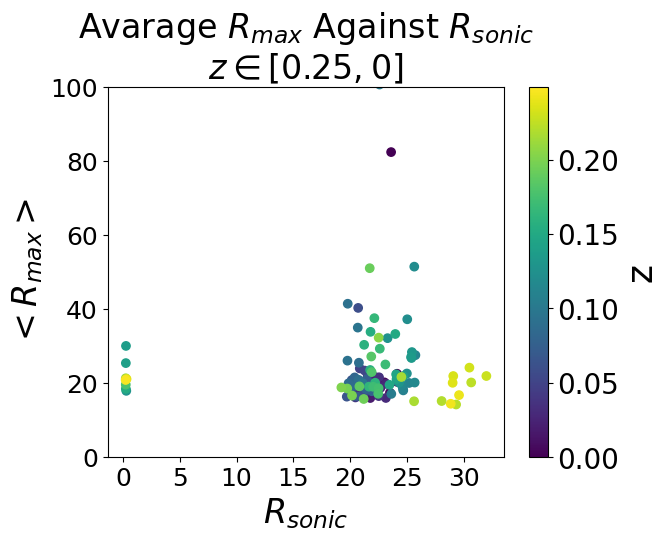

In [26]:
# Plots a graph of <Rmax> against Rsonic
AvarageRmax=np.load("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/TrackingData/TrackingFrom465To600/AvarageRmax.npz",allow_pickle=True)['arr_0']
RsonicForAvarageRmax=np.load("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/TrackingData/TrackingFrom465To600/RsonicForAvarageRmax.npz",allow_pickle=True)['arr_0']
RedshiftsForAvarageRmax=np.load("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/TrackingData/TrackingFrom465To600/RedshiftsForAvarageRmax.npz",allow_pickle=True)['arr_0']
plt.title("Avarage "+r"$R_{max}$"+" Against "+r"$R_{sonic}$"+"\n"+r"$z\in[0.25,0]$",size=24)
plt.xlabel(r"$R_{sonic}$",size=24)
plt.ylabel(r"$<R_{max}>$",size=24)
sc=plt.scatter(RsonicForAvarageRmax,AvarageRmax,c=RedshiftsForAvarageRmax)
cb=plt.colorbar(sc)
cb.ax.tick_params(labelsize=20)
cb.set_label(label="z", size=26)

plt.xticks(size=18)
plt.yticks(size=18)
plt.ylim([0,100])
plt.savefig("Avarage Rmax Against Rsonic for z in [0.25,0].jpg",bbox_inches='tight')
plt.show()

In [33]:
# Tests for different things
# Understand jumps in potential energy by plotting enclosed mass vs. z for several different radii M(<R,z)
AllRedshifts=np.load("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/TrackingData/TrackingFrom465To600/AllRedshifts.npz",allow_pickle=True)['arr_0']
RToCheck=[2,4,6,8,10,12,14,16,18,20,22]
for i in RToCheck:
    MEnclosedForSpecificR=[]
    massProfile0EnclosedForSpecificR=[]
    massProfile1EnclosedForSpecificR=[]
    massProfile2EnclosedForSpecificR=[]
    massProfile4EnclosedForSpecificR=[]
    for j in AllRedshifts:
        MEnclosed,massProfile0Enclosed,massProfile1Enclosed,massProfile2Enclosed,massProfile4Enclosed=FindMEnclosed(j,i)
        MEnclosedForSpecificR.append(MEnclosed)
        massProfile0EnclosedForSpecificR.append(massProfile0Enclosed)
        massProfile1EnclosedForSpecificR.append(massProfile1Enclosed)
        massProfile2EnclosedForSpecificR.append(massProfile2Enclosed)
        massProfile4EnclosedForSpecificR.append(massProfile4Enclosed)
    np.savez_compressed("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/TrackingData/TrackingFrom465To600/MEnclosedAlongAllRedshiftsForR_"+str(i)+"kpc.npz",MEnclosedForSpecificR,dtype=float)
    np.savez_compressed("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/TrackingData/TrackingFrom465To600/massProfile0EnclosedAlongAllRedshiftsForR_"+str(i)+"kpc.npz",massProfile0EnclosedForSpecificR,dtype=float)
    np.savez_compressed("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/TrackingData/TrackingFrom465To600/massProfile1EnclosedAlongAllRedshiftsForR_"+str(i)+"kpc.npz",massProfile1EnclosedForSpecificR,dtype=float)
    np.savez_compressed("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/TrackingData/TrackingFrom465To600/massProfile2EnclosedAlongAllRedshiftsForR_"+str(i)+"kpc.npz",massProfile2EnclosedForSpecificR,dtype=float)
    np.savez_compressed("/home1/08289/tg875885/radial_to_rotating_flows/Aharon/OutflowsCGM/TrackingData/TrackingFrom465To600/massProfile4EnclosedAlongAllRedshiftsForR_"+str(i)+"kpc.npz",massProfile4EnclosedForSpecificR,dtype=float)